In [235]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import geopandas as gpd
import shapely as shp
from shapely.geometry import Point, LineString, Polygon, MultiPolygon
import plotly.express as px
import os

In [236]:
os.chdir("/Users/sarahboukhari/Documents/M1/S8/datavisu/dataviz")

In [237]:
generaliste = pd.ExcelFile("data/aplg.xlsx")
generaliste.sheet_names

['Paramètres', 'APL 2022', 'APL 2023']

In [238]:
generaliste_2023 = pd.read_excel(
    generaliste,
    sheet_name= 2,
    skiprows= 8
)
generaliste_2023
generaliste_2023 = generaliste_2023.dropna(subset=["Commune"])

In [239]:
generaliste_2023.columns

Index(['Code commune INSEE', 'Commune', 'APL aux médecins généralistes',
       'APL aux médecins généralistes de 65 ans et moins ',
       'APL aux médecins généralistes de 62 ans et moins ',
       'APL aux médecins généralistes de 60 ans et moins ',
       'Population standardisée 2021 pour la médecine générale',
       'Population totale 2021'],
      dtype='object')

In [240]:
generaliste_2023["Departement"] = generaliste_2023["Code commune INSEE"].str[:2]

generaliste_2023["Departement"]

1        01
2        01
3        01
4        01
5        01
         ..
34950    97
34951    97
34952    97
34953    97
34954    97
Name: Departement, Length: 34954, dtype: object

In [241]:
fig = px.box(
    generaliste_2023, 
    x='APL aux médecins généralistes', 
    title="Distribution de l'accès aux medecins generalistes")
fig.show()

In [242]:
communes = gpd.read_file("data/admincarto/livraison/COMMUNE.shp")

<Axes: >

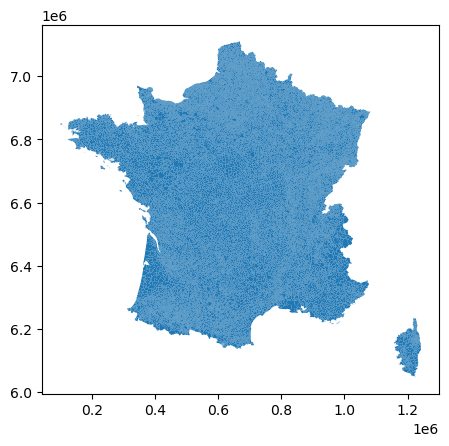

In [243]:
communes.plot()

In [244]:
generaliste_2023["Code commune INSEE"] = generaliste_2023["Code commune INSEE"].astype(str)
communes["INSEE_COM"] = communes["INSEE_COM"].astype(str)

In [245]:
gdf = communes.merge(
    generaliste_2023,
    left_on="INSEE_COM",
    right_on="Code commune INSEE",
    how="left"
)

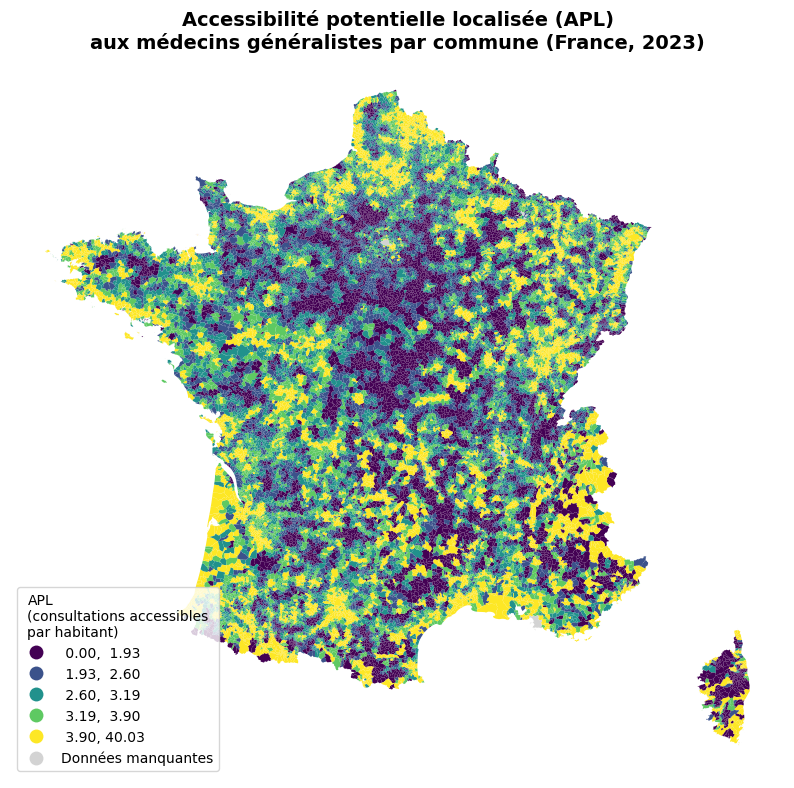

In [246]:
fig, ax = plt.subplots(figsize=(10, 10))

gdf.plot(
    column="APL aux médecins généralistes",
    scheme="quantiles", 
    k=5,                 
    cmap="viridis",
    linewidth=0,
    legend=True,
    ax=ax,
    missing_kwds={
        "color": "lightgrey",
        "label": "Données manquantes"
    },
    legend_kwds={
        "title": "APL\n(consultations accessibles\npar habitant)",
        "loc": "lower left"
    }
)

ax.set_title(
    "Accessibilité potentielle localisée (APL)\n"
    "aux médecins généralistes par commune (France, 2023)",
    fontsize=14,
    fontweight="bold"
)

ax.axis("off")
plt.show()


In [247]:
gdf["DEP"] = gdf["INSEE_COM"].str[:2]

gdf_dep = gdf.dissolve(
    by="DEP",
    aggfunc={
        "APL aux médecins généralistes": "mean"
    }
)

gdf_dep = gdf_dep.reset_index()

In [248]:
gdf_dep["geometry"] = gdf_dep["geometry"].simplify(500)

gdf_dep["APL aux médecins généralistes"] = pd.to_numeric(
    gdf_dep["APL aux médecins généralistes"],
    errors="coerce"
)

gdf_dep.crs = "EPSG:2154"
gdf_dep = gdf_dep.to_crs("EPSG:4326")

In [249]:
fig = px.choropleth_map(
    gdf_dep,
    geojson=gdf_dep.__geo_interface__,
    locations="DEP",
    featureidkey="properties.DEP",
    color="APL aux médecins généralistes",
    color_continuous_scale="Viridis",
    center={"lat": 46.6, "lon": 2.5},
    map_style="carto-positron",
    zoom=4.8
)

fig.update_layout(
    title={
        "text": "Accessibilité potentielle localisée (APL)<br>aux médecins généralistes par département (France, 2023)",
        "x": 0.5
    },
    margin={"r":0,"t":50,"l":0,"b":0}
)

fig.show()

In [250]:
departement = gpd.read_file("data/admincarto/livraison/DEPARTEMENT.shp")[["INSEE_DEP", "NOM", "geometry"]]

In [251]:
departement.columns

Index(['INSEE_DEP', 'NOM', 'geometry'], dtype='object')

In [252]:
departement["geometry"] = departement["geometry"].simplify(
    tolerance=1000, preserve_topology=True
)


gdf2 = departement.merge(
    generaliste_2023,
    left_on="INSEE_DEP",
    right_on="Departement",
    how="left"
)

gdf2.columns

Index(['INSEE_DEP', 'NOM', 'geometry', 'Code commune INSEE', 'Commune',
       'APL aux médecins généralistes',
       'APL aux médecins généralistes de 65 ans et moins ',
       'APL aux médecins généralistes de 62 ans et moins ',
       'APL aux médecins généralistes de 60 ans et moins ',
       'Population standardisée 2021 pour la médecine générale',
       'Population totale 2021', 'Departement'],
      dtype='object')

In [253]:

gdf_dep2 = gdf2.dissolve(
    by="INSEE_DEP",
    aggfunc={
        "APL aux médecins généralistes": "mean",
        "NOM": "first"  
    }
).reset_index()

gdf_dep2 = gdf_dep2.to_crs(epsg=4326)

gdf_dep2["APL aux médecins généralistes"] = pd.to_numeric(
    gdf_dep2["APL aux médecins généralistes"], errors="coerce"
)

fig = px.choropleth_map(
    gdf_dep2,
    geojson=gdf_dep2.geometry,
    locations=gdf_dep2.index,
    color="APL aux médecins généralistes",
    color_continuous_scale="Viridis",
    center={"lat": 46.6, "lon": 2.5},
    zoom=4.8,
    map_style="carto-positron",
    hover_name="NOM"   
)

fig.update_layout(
    title={
        "text": "Accessibilité potentielle localisée (APL)<br>aux médecins généralistes par département (France, 2023)",
        "x": 0.5
    },
    margin={"r":0,"t":50,"l":0,"b":0}
)

fig.show()


In [254]:
gdf.columns

Index(['ID', 'NOM', 'NOM_M', 'INSEE_COM', 'STATUT', 'POPULATION', 'INSEE_CAN',
       'INSEE_ARR', 'INSEE_DEP', 'INSEE_REG', 'SIREN_EPCI', 'geometry',
       'Code commune INSEE', 'Commune', 'APL aux médecins généralistes',
       'APL aux médecins généralistes de 65 ans et moins ',
       'APL aux médecins généralistes de 62 ans et moins ',
       'APL aux médecins généralistes de 60 ans et moins ',
       'Population standardisée 2021 pour la médecine générale',
       'Population totale 2021', 'Departement', 'DEP'],
      dtype='object')

In [255]:
arrondissement = gpd.read_file("data/admincarto/livraison/ARRONDISSEMENT_MUNICIPAL.shp")[["INSEE_ARM", "NOM", "geometry"]]
arrondissement.head()

INSEE_ARM                           NOM  \
0     13208   Marseille 8e Arrondissement   
1     13215  Marseille 15e Arrondissement   
2     75102       Paris 2e Arrondissement   
3     13201  Marseille 1er Arrondissement   
4     75112      Paris 12e Arrondissement   

                                            geometry  
0  MULTIPOLYGON (((892850.1 6241794.8, 892851.1 6...  
1  POLYGON ((889641.8 6255921.7, 889737.3 6255898...  
2  POLYGON ((652167.8 6863604.3, 652469.9 6863505...  
3  POLYGON ((893676.7 6246828.4, 893573.9 6246883...  
4  POLYGON ((660902.4 6860026.2, 660945.5 6859953...

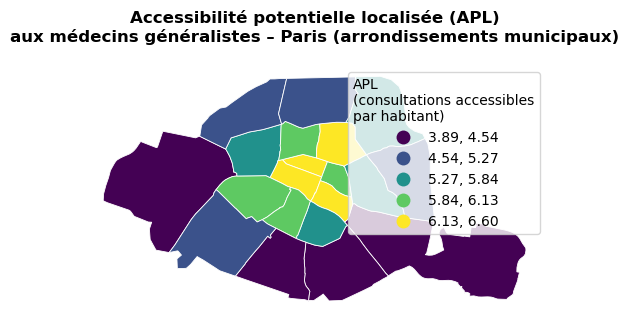

In [256]:

APL_ARR_COL = "Commune" 

generaliste_2023 = generaliste_2023[[APL_ARR_COL, "APL aux médecins généralistes"]].copy()

generaliste_2023["APL aux médecins généralistes"] = pd.to_numeric(
    generaliste_2023["APL aux médecins généralistes"],
    errors="coerce"
)

apl_paris = generaliste_2023[
    generaliste_2023[APL_ARR_COL].str.startswith("Paris")
].copy()

arr_paris = arrondissement[arrondissement["NOM"].str.startswith("Paris")].copy()

gdf_paris = arr_paris.merge(
    apl_paris,
    left_on="NOM",
    right_on=APL_ARR_COL,
    how="left"
)

fig, ax = plt.subplots(figsize=(6, 6))

gdf_paris.plot(
    column="APL aux médecins généralistes",
    scheme="quantiles",
    k=5,
    cmap="viridis",
    linewidth=0.6,
    edgecolor="white",
    legend=True,
    ax=ax,
    missing_kwds={
        "color": "lightgrey",
        "label": "Données manquantes"
    },
    legend_kwds={
        "title": "APL\n(consultations accessibles\npar habitant)"
    }
)

ax.set_title(
    "Accessibilité potentielle localisée (APL)\n"
    "aux médecins généralistes – Paris (arrondissements municipaux)",
    fontsize=12,
    fontweight="bold"
)

ax.axis("off")
plt.show()


In [257]:
pauvrete = pd.read_csv("data/pauvrete/BASE_TD_FILO_IRIS_2021_DISP.csv" , sep=";")
pauvrete.head()

IRIS DISP_TP6021 DISP_INCERT21 DISP_Q121 DISP_MED21 DISP_Q321  \
0  010040101        19,0             2     14990      20350     26140   
1  010040102        25,0             1     13880      18570     24760   
2  010040201        19,0             1     15190      20700     27180   
3  010040202         8,0             1     19600      25230     33170   
4  010330102        24,0             1     14050      20420     29640   

  DISP_EQ21 DISP_D121 DISP_D221 DISP_D321  ... DISP_PCHO21 DISP_PBEN21  \
0      0,55     11620     14280     16080  ...         3,0         3,6   
1      0,59     10580     12890     14660  ...         4,2         2,4   
2      0,58     11400     14060     16320  ...         3,5         4,0   
3      0,54     14810     18310     20780  ...         2,4         3,6   
4      0,76      9410     12570     15130  ...         4,9         1,9   

  DISP_PPEN21 DISP_PPAT21 DISP_PPSOC21 DISP_PPFAM21 DISP_PPMINI21  \
0        26,9         6,2          8,6          3,3           3,8   
1        24,9         5,8         11,1          3,7           5,1   
2        27,2         6,4          7,7          2,8           3,3   
3        23,8        16,2          4,0          1,8           1,5   
4        23,7         5,2          5,3          1,5           2,5   

  DISP_PPLOGT21 DISP_PIMPOT21 DISP_NOTE21  
0           1,5         -12,5           0  
1           2,3         -12,4           0  
2           1,6         -13,8           0  
3           0,7         -17,3           0  
4           1,3         -13,1           0  

[5 rows x 30 columns]

In [258]:
pauvrete.columns

Index(['IRIS', 'DISP_TP6021', 'DISP_INCERT21', 'DISP_Q121', 'DISP_MED21',
       'DISP_Q321', 'DISP_EQ21', 'DISP_D121', 'DISP_D221', 'DISP_D321',
       'DISP_D421', 'DISP_D621', 'DISP_D721', 'DISP_D821', 'DISP_D921',
       'DISP_RD21', 'DISP_S80S2021', 'DISP_GI21', 'DISP_PACT21', 'DISP_PTSA21',
       'DISP_PCHO21', 'DISP_PBEN21', 'DISP_PPEN21', 'DISP_PPAT21',
       'DISP_PPSOC21', 'DISP_PPFAM21', 'DISP_PPMINI21', 'DISP_PPLOGT21',
       'DISP_PIMPOT21', 'DISP_NOTE21'],
      dtype='object')

In [259]:
cols = ['DISP_MED21', 'DISP_TP6021', 'DISP_GI21']
pauvrete1 = pauvrete[cols].copy()

for c in cols:
    print(c)
    print(data[c].value_counts().head(5))
    print()


DISP_MED21
DISP_MED21
21960.0    25
21480.0    22
22210.0    22
23610.0    22
21040.0    21
Name: count, dtype: int64

DISP_TP6021
DISP_TP6021
ns      1209
11,0     895
9,0      887
13,0     808
7,0      799
Name: count, dtype: int64

DISP_GI21
DISP_GI21
ns       1209
nd        327
0,250     167
0,255     160
0,245     156
Name: count, dtype: int64



In [260]:
pauvrete1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16026 entries, 0 to 16025
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   DISP_MED21   16026 non-null  object
 1   DISP_TP6021  16026 non-null  object
 2   DISP_GI21    16026 non-null  object
dtypes: object(3)
memory usage: 375.7+ KB


In [261]:
for c in cols:
    pauvrete1[c] = (
        pauvrete1[c]
        .astype(str)
        .str.replace(',', '.', regex=False)
        .replace(['ns', 'nd'], np.nan)
    )
    pauvrete1[c] = pd.to_numeric(pauvrete1[c], errors='coerce')

In [262]:
pauvrete1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16026 entries, 0 to 16025
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DISP_MED21   14490 non-null  float64
 1   DISP_TP6021  14486 non-null  float64
 2   DISP_GI21    14490 non-null  float64
dtypes: float64(3)
memory usage: 375.7 KB


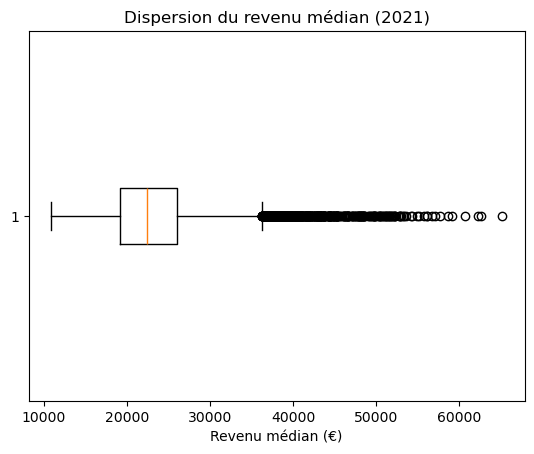

In [263]:
plt.figure()
plt.boxplot(data['DISP_MED21'].dropna(), vert=False)
plt.xlabel("Revenu médian (€)")
plt.title("Dispersion du revenu médian (2021)")
plt.show()


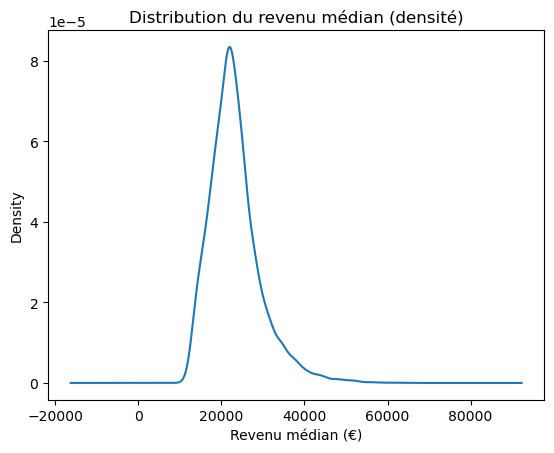

In [264]:
plt.figure()
data['DISP_MED21'].dropna().plot(kind='density')
plt.xlabel("Revenu médian (€)")
plt.title("Distribution du revenu médian (densité)")
plt.show()


In [265]:
import pandas as pd
import numpy as np

cols = ['DISP_MED21', 'DISP_TP6021', 'DISP_GI21']

for c in cols:
    pauvrete[c] = (
        pauvrete[c]
        .astype(str)
        .str.replace(',', '.', regex=False)
    )

pauvrete[cols] = pauvrete[cols].replace(['ns', 'nd'], np.nan)
pauvrete[cols] = pauvrete[cols].apply(pd.to_numeric, errors='coerce')



In [266]:
pauvrete['Code commune INSEE'] = pauvrete['IRIS'].str[:5]

pauvrete_commune = (
    pauvrete
    .groupby('Code commune INSEE')[cols]
    .mean()
    .reset_index()
)


In [267]:
df_final = pd.merge(
    gdf2[['Code commune INSEE', 'APL aux médecins généralistes']],
    pauvrete_commune,
    on='Code commune INSEE',
    how='inner'
)


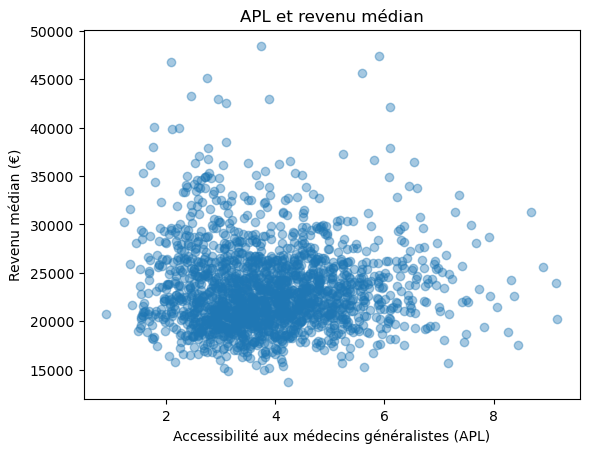

In [268]:
plt.figure()
plt.scatter(
    df_final['APL aux médecins généralistes'],
    df_final['DISP_MED21'],
    alpha=0.4
)
plt.xlabel("Accessibilité aux médecins généralistes (APL)")
plt.ylabel("Revenu médian (€)")
plt.title("APL et revenu médian")
plt.show()


In [269]:

typologie = gpd.read_file("data/typologie")
typologie.columns


Index(['id_ddtm62', 'inseecom', 'nomcom', 'code_typo', 'nom_typo', 'obs1',
       'obs2', 'obs3', 'obs4', 'geometry'],
      dtype='object')

In [270]:
# on enlève la géométrie
typologie = typologie.drop(columns='geometry')

# on renomme proprement
typologie = typologie.rename(columns={
    'inseecom': 'Code commune INSEE',
    'nom_typo': 'Typologie'
})

# on s'assure que le code commune est une string
typologie['Code commune INSEE'] = typologie['Code commune INSEE'].astype(str)

typologie.columns

Index(['id_ddtm62', 'Code commune INSEE', 'nomcom', 'code_typo', 'Typologie',
       'obs1', 'obs2', 'obs3', 'obs4'],
      dtype='object')

In [271]:
typologie['Code commune INSEE'].nunique()


890

In [272]:
set(gdf2['Code commune INSEE']) - set(typologie['Code commune INSEE'])


{'76050',
 '22178',
 '23074',
 '41137',
 '07328',
 '29034',
 '09318',
 '47029',
 '35040',
 '88516',
 '68292',
 '80123',
 '10039',
 '17471',
 '35060',
 '43127',
 '52547',
 '46091',
 '03117',
 '44050',
 '51359',
 '60655',
 '03186',
 '79153',
 '31557',
 '35322',
 '55301',
 '31514',
 '38054',
 '52457',
 '02155',
 '88479',
 '76402',
 '59383',
 '27427',
 '37159',
 '88341',
 '42161',
 '88457',
 '01065',
 '16198',
 '56078',
 '60600',
 '11159',
 '09168',
 '53091',
 '63232',
 '64551',
 '95256',
 '2B075',
 '46168',
 '33022',
 '65435',
 '55043',
 '52095',
 '76711',
 '54300',
 '23191',
 '70106',
 '91109',
 '44078',
 '19051',
 '12180',
 '77109',
 '11401',
 '57587',
 '59120',
 '10330',
 '60399',
 '68250',
 '85191',
 '38158',
 '28109',
 '32283',
 '17332',
 '28168',
 '12161',
 '39096',
 '65279',
 '80571',
 '74294',
 '32466',
 '16215',
 '01072',
 '54256',
 '10418',
 '31270',
 '12090',
 '76592',
 '86280',
 '12003',
 '53200',
 '91556',
 '95254',
 '02803',
 '88374',
 '17161',
 '61097',
 '10393',
 '46193',


In [273]:
apl_typo = gdf2.merge(
    typologie[['Code commune INSEE', 'Typologie']],
    on='Code commune INSEE',
    how='inner'
)

apl_typo['Typologie'].head(10)


0             Urbain densité intermédiaire
1     Rural sous forte influence d'un pôle
2     Rural sous forte influence d'un pôle
3                             Urbain dense
4    Rural sous faible influence d'un pôle
5    Rural sous faible influence d'un pôle
6     Rural sous forte influence d'un pôle
7    Rural sous faible influence d'un pôle
8     Rural sous forte influence d'un pôle
9    Rural sous faible influence d'un pôle
Name: Typologie, dtype: object

<Figure size 1200x600 with 0 Axes>

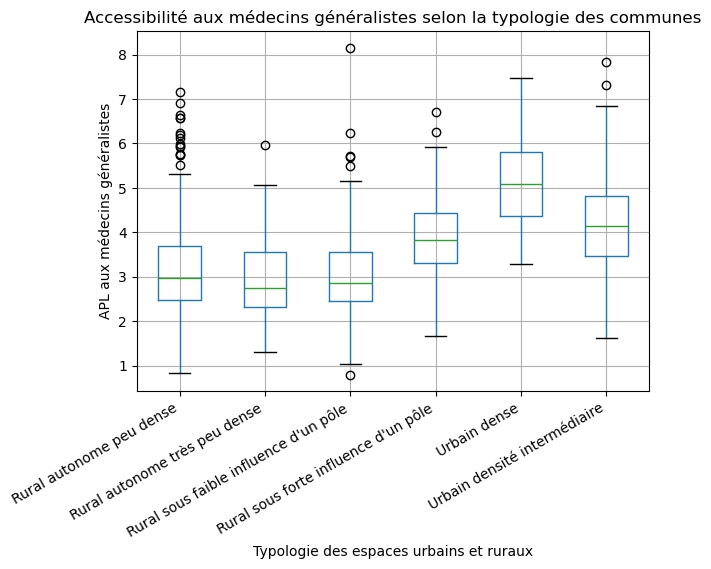

In [274]:
plt.figure(figsize=(12, 6))

apl_typo.boxplot(
    column='APL aux médecins généralistes',
    by='Typologie'
)

plt.suptitle("")
plt.title("Accessibilité aux médecins généralistes selon la typologie des communes")
plt.xlabel("Typologie des espaces urbains et ruraux")
plt.ylabel("APL aux médecins généralistes")

plt.xticks(rotation=30, ha='right')  

plt.show()


In [275]:
typologie.columns
#DISP_TP6021 = taux de pauvrete
#DISP_MED21

Index(['id_ddtm62', 'Code commune INSEE', 'nomcom', 'code_typo', 'Typologie',
       'obs1', 'obs2', 'obs3', 'obs4'],
      dtype='object')

<Figure size 1200x600 with 0 Axes>

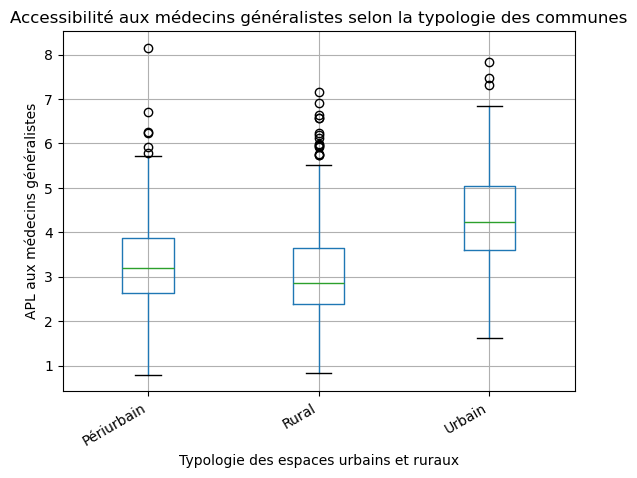

In [ ]:

apl_typo['Typologie_simple'] = apl_typo['Typologie'].replace({
    'Rural autonome peu dense': 'Rural',
    'Rural autonome très peu dense': 'Rural',
    'Rural sous faible influence d\'un pôle': 'Périurbain',
    'Rural sous forte influence d\'un pôle': 'Périurbain',
    'Urbain densité intermédiaire': 'Urbain',
    'Urbain dense': 'Urbain'
})

plt.figure(figsize=(12, 6))

apl_typo.boxplot(
    column='APL aux médecins généralistes',
    by='Typologie_simple'
)

plt.suptitle("")
plt.title("Accessibilité aux médecins généralistes selon la typologie des communes")
plt.xlabel("Typologie des espaces urbains et ruraux")
plt.ylabel("APL aux médecins généralistes")

plt.xticks(rotation=30, ha='right')  

plt.show()


In [277]:
age = pd.read_excel("data/age/age-insee-2020.xlsx")
age.head()

INSEE                      NOM       EPCI DEP  REG        F0-2        F3-5  \
0  1001  L'Abergement-Clémenciat  200069193  D1  R84   13.414280   12.509227   
1  1002    L'Abergement-de-Varey  240100883  D1  R84    2.994218    6.050262   
2  1004        Ambérieu-en-Bugey  240100883  D1  R84  294.667755  245.153009   
3  1005      Ambérieux-en-Dombes  200042497  D1  R84   28.000000   33.000000   
4  1006                  Ambléon  200040350  D1  R84    0.991228    1.982456   

        F6-10      F11-17      F18-24  ...        H0-2        H3-5  \
0   19.214486   37.181506   14.062216  ...   18.070033   14.402520   
1   12.232163   11.868718    5.201595  ...    2.994218    6.116081   
2  382.800636  599.105269  680.830755  ...  256.303606  289.985107   
3   60.000000   79.000000   50.000000  ...   35.000000   36.000000   
4    1.982456    0.991228    1.982456  ...    1.982456    0.991228   

        H6-10      H11-17      H18-24       H25-39       H40-54      H55-64  \
0   34.539704   40.257329   14.231465    72.497916    81.849108   61.039016   
1    6.953040   22.349436    6.393815    19.540481    37.479209   10.977019   
2  485.793199  613.181777  669.385044  1542.699092  1238.119870  782.771068   
3   65.000000   78.000000   51.000000   181.000000   183.000000  124.000000   
4    1.982456    0.991228    3.964912    11.894737    10.903509   13.877193   

       H65-79        H80+  
0   55.240275   18.352851  
1   15.687170    8.878739  
2  750.039923  252.363550  
3  108.000000   32.000000  
4   10.903509    1.982456  

[5 rows x 26 columns]